
Found 10042 images belonging to 2 classes.
Found 2154 images belonging to 2 classes.
Found 2152 images belonging to 2 classes.



Epoch 1/10


1256/1256 [==============================] - ETA: 0s - loss: 0.1920 - accuracy: 0.9338
Epoch 1: val_loss improved from inf to 0.05724, saving model to inceptionv3.keras
1256/1256 [==============================] - 311s 242ms/step - loss: 0.1920 - accuracy: 0.9338 - val_loss: 0.0572 - val_accuracy: 0.9824
Epoch 2/10
1256/1256 [==============================] - ETA: 0s - loss: 0.1288 - accuracy: 0.9487
Epoch 2: val_loss improved from 0.05724 to 0.05716, saving model to inceptionv3.keras
1256/1256 [==============================] - 295s 235ms/step - loss: 0.1288 - accuracy: 0.9487 - val_loss: 0.0572 - val_accuracy: 0.9814
Epoch 3/10
1256/1256 [==============================] - ETA: 0s - loss: 0.1122 - accuracy: 0.9606
Epoch 3: val_loss improved from 0.05716 to 0.04718, saving model to inceptionv3.keras
1256/1256 [==============================] - 

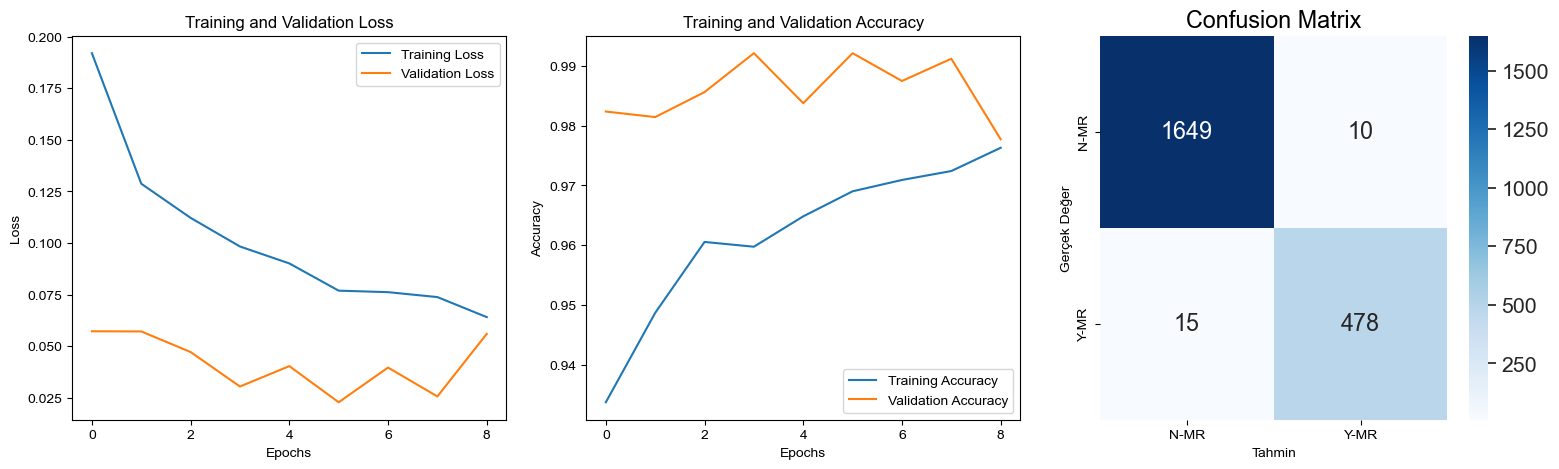


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1659
           1       0.98      0.97      0.97       493

    accuracy                           0.99      2152
   macro avg       0.99      0.98      0.98      2152
weighted avg       0.99      0.99      0.99      2152



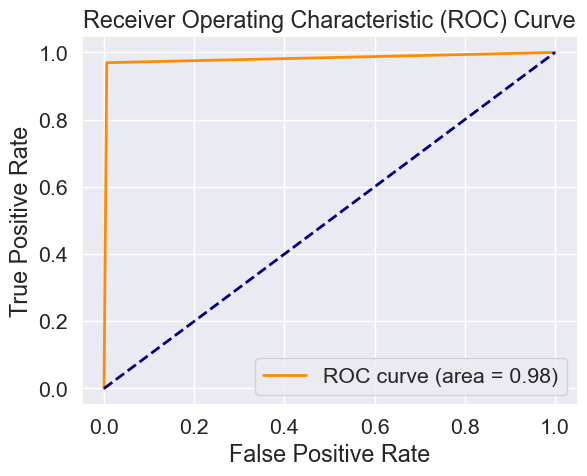

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Early stopping callback'i oluşturma
early_stopping = EarlyStopping(
    monitor='val_loss',  # Takip edilecek metrik (örneğin, doğrulama kaybı)
    patience=3,  # Metrik iyileşmediğinde veya durduğunda beklenen epoch sayısı
    restore_best_weights=True  # En iyi ağırlıkları geri yükleme
)

# Define image dataset
WIDTH, HEIGHT = 128, 128
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0, shear_range=0.25, horizontal_flip=True, rotation_range=20)

train_dataset = image_generator.flow_from_directory(
    batch_size=8,
    directory=r"C:\Users\User\Desktop\YenivEeri\train",
    shuffle=True,
    target_size=(WIDTH, HEIGHT),
    subset="training",
    class_mode='categorical'
)

image_generator_submission = ImageDataGenerator(rescale=1/255, validation_split=0.5)
validation = image_generator_submission.flow_from_directory(
    batch_size=8,
    directory=r"C:\Users\User\Desktop\YenivEeri\test",
    shuffle=False,
    target_size=(WIDTH, HEIGHT),
    subset="training",
    class_mode='categorical'
)

test_dataset = image_generator_submission.flow_from_directory(
    directory=r"C:\Users\User\Desktop\YenivEeri\test",
    shuffle=False,
    target_size=(WIDTH, HEIGHT),
    subset="validation",
    class_mode=None
)

# InceptionV3 modelini yükleme
inceptionv3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(WIDTH, HEIGHT, 3))

# Yeni model oluşturma
model = Sequential([
    inceptionv3_model,  # InceptionV3 modelini ekliyoruz
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_dataset.num_classes, activation='softmax')
])

# Katmanları dondurma
for layer in inceptionv3_model.layers:
    layer.trainable = False

# Modeli derleme
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

inceptionv3_checkpoint = ModelCheckpoint('inceptionv3.keras', verbose=1, save_best_only=True)

# Model eğitimi
history = model.fit(train_dataset, epochs=10, validation_data=validation, callbacks=[early_stopping, inceptionv3_checkpoint])

# Eğitim ve doğrulama kaybı ve doğruluğu görselleştirme
plt.figure(figsize=(16, 5))

# Eğitim ve doğrulama kaybı
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Eğitim ve doğrulama doğruluğu
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Confusion Matrix
predictions = model.predict(test_dataset)
y_pred = np.argmax(predictions, axis=1)
y_true = test_dataset.labels
conf_matrix = confusion_matrix(y_true, y_pred)

# Karışıklık matrisini görselleştirme
plt.subplot(1, 3, 3)
sns.set(font_scale=1.4)  # Font ölçeğini ayarla
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['N-MR', 'Y-MR'],
            yticklabels=['N-MR', 'Y-MR'])
plt.xlabel('Tahmin')
plt.ylabel('Gerçek Değer')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

# Classification Report
class_report = classification_report(y_true, y_pred)
print("\nClassification Report:")
print(class_report)

# ROC Eğrisi ve AUC
fpr, tpr, _ = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()



In [3]:
# Define image dataset
WIDTH, HEIGHT = 128, 128
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0, shear_range=0.25, horizontal_flip=True, rotation_range=20)

train_dataset = image_generator.flow_from_directory(
    batch_size=8,
    directory=r"C:\Users\User\Desktop\YenivEeri\train",
    shuffle=True,
    target_size=(WIDTH, HEIGHT),
    subset="training",
    class_mode='categorical'
)

image_generator_submission = ImageDataGenerator(rescale=1/255, validation_split=0.5)
validation = image_generator_submission.flow_from_directory(
    batch_size=8,
    directory=r"C:\Users\User\Desktop\YenivEeri\test",
    shuffle=False,
    target_size=(WIDTH, HEIGHT),
    subset="training",
    class_mode='categorical'
)

test_dataset = image_generator_submission.flow_from_directory(
    directory=r"C:\Users\User\Desktop\YenivEeri\test",
    shuffle=False,
    target_size=(WIDTH, HEIGHT),
    subset="validation",
    class_mode=None
)


Found 10042 images belonging to 2 classes.
Found 2154 images belonging to 2 classes.
Found 2152 images belonging to 2 classes.


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model


inceptionV3_model=load_model("inceptionv3.keras")




inceptionV3_predictions=inceptionV3_model.predict(test_dataset)



inceptionV3_true_classes=test_dataset.classes


68/68 [==============================] - 49s 684ms/step


In [7]:
categories={0:'N-MR', 1:'Y-MR'}
inceptionV3_predicted_classes = np.argmax(inceptionV3_predictions, axis=1)

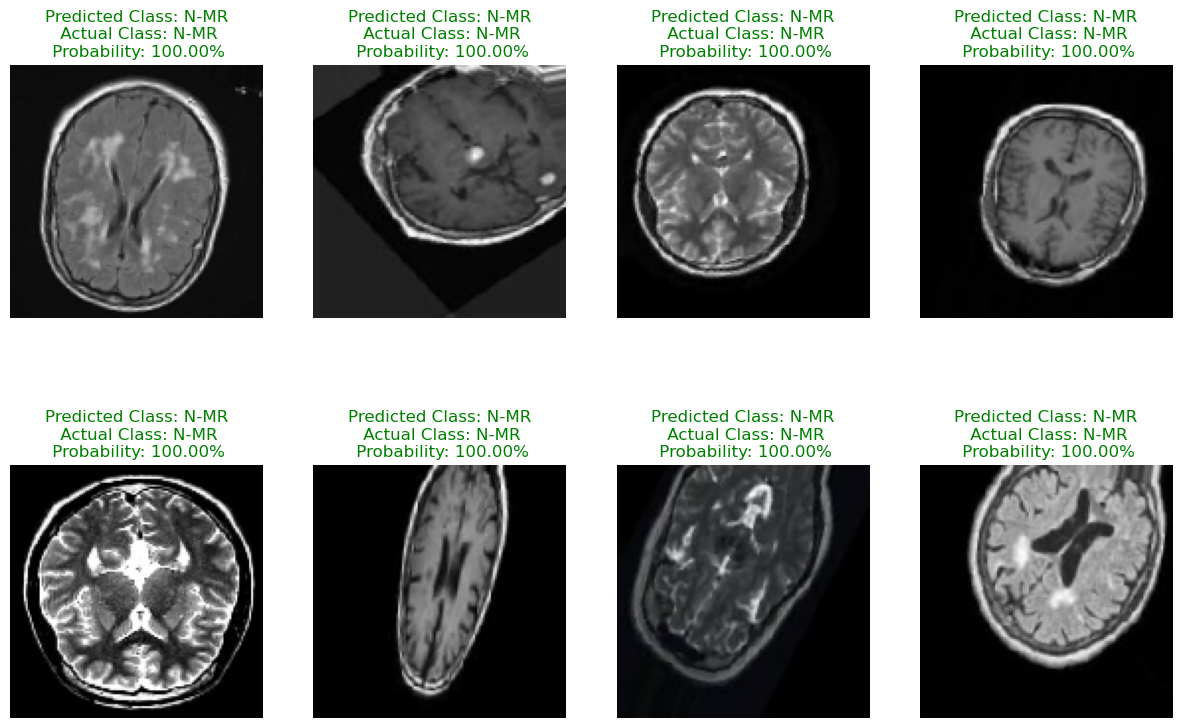

In [9]:
predicted_classes = np.argmax(inceptionV3_predictions, axis=1)  # En yüksek olasılığa sahip sınıfları al
prediction_probabilities = np.max(inceptionV3_predictions, axis=1)  # En yüksek olasılıkları al
batch_1_img = train_dataset[0]
plt.figure(figsize=(15,15))
for i in range(8):
    plt.subplot(5,4,i+1)
    plt.imshow(batch_1_img[0][i])
    predicted_class_label=categories[inceptionV3_predicted_classes[i]]
    actual_class_label=categories[inceptionV3_true_classes[i]]

    if inceptionV3_predicted_classes[i] == inceptionV3_true_classes[i]:
        title_color='green'
    else:
        title_color='red'

    prediction_probability = prediction_probabilities[i] * 100

    title = f'Predicted Class: {predicted_class_label}\n Actual Class: {actual_class_label}\n Probability: {prediction_probability:.2f}%'
    plt.title(title,color=title_color)
    plt.axis('off')
plt.subplots_adjust(top=1.4)
plt.show()
